In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import time
from scipy.stats import linregress

In [2]:
CSV_FILE = "global_emissions.csv"
PARQUET_FILE = "global_emissions.parquet"
CHUNKSIZE = 1000

if not os.path.exists(PARQUET_FILE):
    print("Создание Parquet файла...")
    chunks = pd.read_csv(CSV_FILE, chunksize=CHUNKSIZE)
    df = pd.concat(chunks)
    df.to_parquet(PARQUET_FILE)
    print("Parquet файл создан")

start = time.time()
df_csv = pd.read_csv(CSV_FILE)
csv_time = time.time() - start

start = time.time()
df_parquet = pd.read_parquet(PARQUET_FILE)
parquet_time = time.time() - start

print(f"CSV: {csv_time:.3f}с, Parquet: {parquet_time:.3f}с")
print(f"Parquet быстрее в {csv_time/parquet_time:.1f} раз")

CSV: 0.007с, Parquet: 0.020с
Parquet быстрее в 0.3 раз


In [3]:
def task1_analysis():
    """3 самые 'зеленые' и 3 самые 'грязные' страны по выбросам на душу населения"""
    country_emissions = {}
    
    for chunk in pd.read_csv(CSV_FILE, chunksize=CHUNKSIZE):
        for _, row in chunk.iterrows():
            country = row['Country.Name']
            emissions = row['Emissions.Production.CO2.Total']
            population = row['Country.Population']
            
            if population > 0:
                per_capita = emissions / population
                if country not in country_emissions:
                    country_emissions[country] = []
                country_emissions[country].append(per_capita)
    
    avg_emissions = {country: np.mean(values) for country, values in country_emissions.items()}
    sorted_countries = sorted(avg_emissions.items(), key=lambda x: x[1])
    
    greenest = sorted_countries[:3]
    dirtiest = sorted_countries[-3:]
    
    return greenest, dirtiest

greenest, dirtiest = task1_analysis()

print("Самые 'зеленые' страны:")
for country, value in greenest:
    print(f"  {country}: {value:.10f}")

print("\nСамые 'грязные' страны:")
for country, value in dirtiest:
    print(f"  {country}: {value:.6f}")

Самые 'зеленые' страны:
  Tanzania: 0.0000001326
  Afghanistan: 0.0000001359
  Myanmar: 0.0000002500

Самые 'грязные' страны:
  United Arab Emirates: 0.000025
  Kuwait: 0.000028
  Qatar: 0.000051


In [ ]:
def task2_analysis():
    """3 страны с наибольшим и наименьшим разбросом выбросов"""
    country_data = {}
    
    for chunk in pd.read_csv(CSV_FILE, chunksize=CHUNKSIZE):
        for _, row in chunk.iterrows():
            country = row['Country.Name']
            emissions = row['Emissions.Production.CO2.Total']
            
            if country not in country_data:
                country_data[country] = []
            country_data[country].append(emissions)
    
    country_stats = {}
    for country, values in country_data.items():
        if len(values) > 1:
            mean = np.mean(values)
            std = np.std(values, ddof=1)
            n = len(values)
            se = std / np.sqrt(n)
            
            ci = stats.t.ppf(0.975, df=n-1) * se
            
            variance = np.var(values, ddof=1)
            
            country_stats[country] = {
                'mean': mean,
                'variance': variance,
                'ci': ci,
                'data': values
            }
    
    sorted_countries = sorted(country_stats.items(), key=lambda x: x[1]['variance'])
    
    lowest_var = [(country, stats['mean'], stats['ci']) for country, stats in sorted_countries[:3]]
    highest_var = [(country, stats['mean'], stats['ci']) for country, stats in sorted_countries[-3:]]
    
    lowest_var_data = [country_stats[country]['data'] for country, _, _ in lowest_var]
    highest_var_data = [country_stats[country]['data'] for country, _, _ in highest_var]
    lowest_var_names = [country for country, _, _ in lowest_var]
    highest_var_names = [country for country, _, _ in highest_var]
    
    return lowest_var, highest_var, lowest_var_data, lowest_var_names, highest_var_data, highest_var_names

lowest_var, highest_var, lowest_var_data, lowest_var_names, highest_var_data, highest_var_names = task2_analysis()

print("Страны с наименьшим разбросом выбросов (среднее ± доверительный интервал):")
for country, mean, ci in lowest_var:
    print(f"  {country}: {mean:.2f} ± {ci:.2f}")

print("\nСтраны с наибольшим разбросом выбросов (среднее ± доверительный интервал):")
for country, mean, ci in highest_var:
    print(f"  {country}: {mean:.2f} ± {ci:.2f}")

Страны с наименьшим разбросом выбросов (среднее ± доверительный интервал):
  Gabon: 4.75 ± 0.14
  Iceland: 3.11 ± 0.19
  Cyprus: 7.17 ± 0.35

Страны с наибольшим разбросом выбросов (среднее ± доверительный интервал):
  United States: 5648.15 ± 124.42
  India: 1396.89 ± 240.71
  China: 6251.70 ± 1136.88


In [ ]:
def task3_analysis():
    """Общие ВВП и выбросы за период наблюдений"""
    yearly_data = {}
    
    for chunk in pd.read_csv(CSV_FILE, chunksize=CHUNKSIZE):
        for _, row in chunk.iterrows():
            year = row['Year']
            gdp = row['Country.GDP']
            emissions = row['Emissions.Production.CO2.Total']
            
            if year not in yearly_data:
                yearly_data[year] = {'gdp': 0, 'emissions': 0}
            
            yearly_data[year]['gdp'] += gdp
            yearly_data[year]['emissions'] += emissions
    
    sorted_years = sorted(yearly_data.items())
    years = [year for year, _ in sorted_years]
    gdp_values = [data['gdp'] for _, data in sorted_years]
    emissions_values = [data['emissions'] for _, data in sorted_years]
    
    return years, gdp_values, emissions_values

years, gdp_values, emissions_values = task3_analysis()


In [ ]:
def additional_analysis():
    """Корреляция между населением и выбросами"""
    df = pd.read_parquet(PARQUET_FILE, columns=['Country.Population', 'Emissions.Production.CO2.Total'])
    
    mask = (df['Country.Population'] > 0) & (df['Emissions.Production.CO2.Total'] > 0)
    df_clean = df[mask].dropna()
    
    population = df_clean['Country.Population'].tolist()
    emissions = df_clean['Emissions.Production.CO2.Total'].tolist()
    correlation = df_clean['Country.Population'].corr(df_clean['Emissions.Production.CO2.Total'])
    
    return population, emissions, correlation

population, emissions, correlation = additional_analysis()

In [ ]:
def plot_all_results(task1_results, task2_results, task3_results, task4_results):
    """Функция для построения всех графиков"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    greenest, dirtiest = task1_results
    all_countries = greenest + dirtiest
    countries = [x[0] for x in all_countries]
    values = [x[1] for x in all_countries]
    colors = ['green'] * 3 + ['red'] * 3
    
    ax1.bar(countries, values, color=colors)
    ax1.set_title('Задание 1: 3 самые "зеленые" и 3 самые "грязные" страны\nпо выбросам на душу населения')
    ax1.set_ylabel('Выбросы на душу населения')
    ax1.tick_params(axis='x', rotation=45)
    
    lowest_var_data, lowest_var_names, highest_var_data, highest_var_names = task2_results
    all_data = lowest_var_data + highest_var_data
    all_names = lowest_var_names + highest_var_names
    
    ax2.boxplot(all_data, labels=all_names)
    ax2.set_title('Задание 2: Страны с наименьшим и наибольшим разбросом выбросов')
    ax2.set_ylabel('Уровень выбросов CO2')
    ax2.tick_params(axis='x', rotation=45)
    
    years, gdp_values, emissions_values = task3_results
    
    gdp_normalized = (gdp_values - np.min(gdp_values)) / (np.max(gdp_values) - np.min(gdp_values))
    emissions_normalized = (emissions_values - np.min(emissions_values)) / (np.max(emissions_values) - np.min(emissions_values))
    
    ax3.plot(years, gdp_normalized, marker='o', label='Нормализованный ВВП')
    ax3.plot(years, emissions_normalized, marker='s', label='Нормализованные выбросы')
    ax3.set_title('Задание 3: Динамика ВВП и выбросов CO2 за период наблюдений')
    ax3.set_xlabel('Год')
    ax3.set_ylabel('Нормализованные значения')
    ax3.legend()
    ax3.grid(True)
    
    population, emissions, corr = task4_results
    
    ax4.scatter(population, emissions, alpha=0.5)
    ax4.set_title(f'Задание 4: Корреляция между населением и выбросами\n(corr = {corr:.3f})')
    ax4.set_xlabel('Население')
    ax4.set_ylabel('Выбросы CO2')
    
    if len(population) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(population, emissions)
        line_x = np.array([min(population), max(population)])
        line_y = intercept + slope * line_x
        ax4.plot(line_x, line_y, 'r-', label='Линия регрессии')
        ax4.legend()
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_29947/2482368219.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(all_data, labels=all_names)


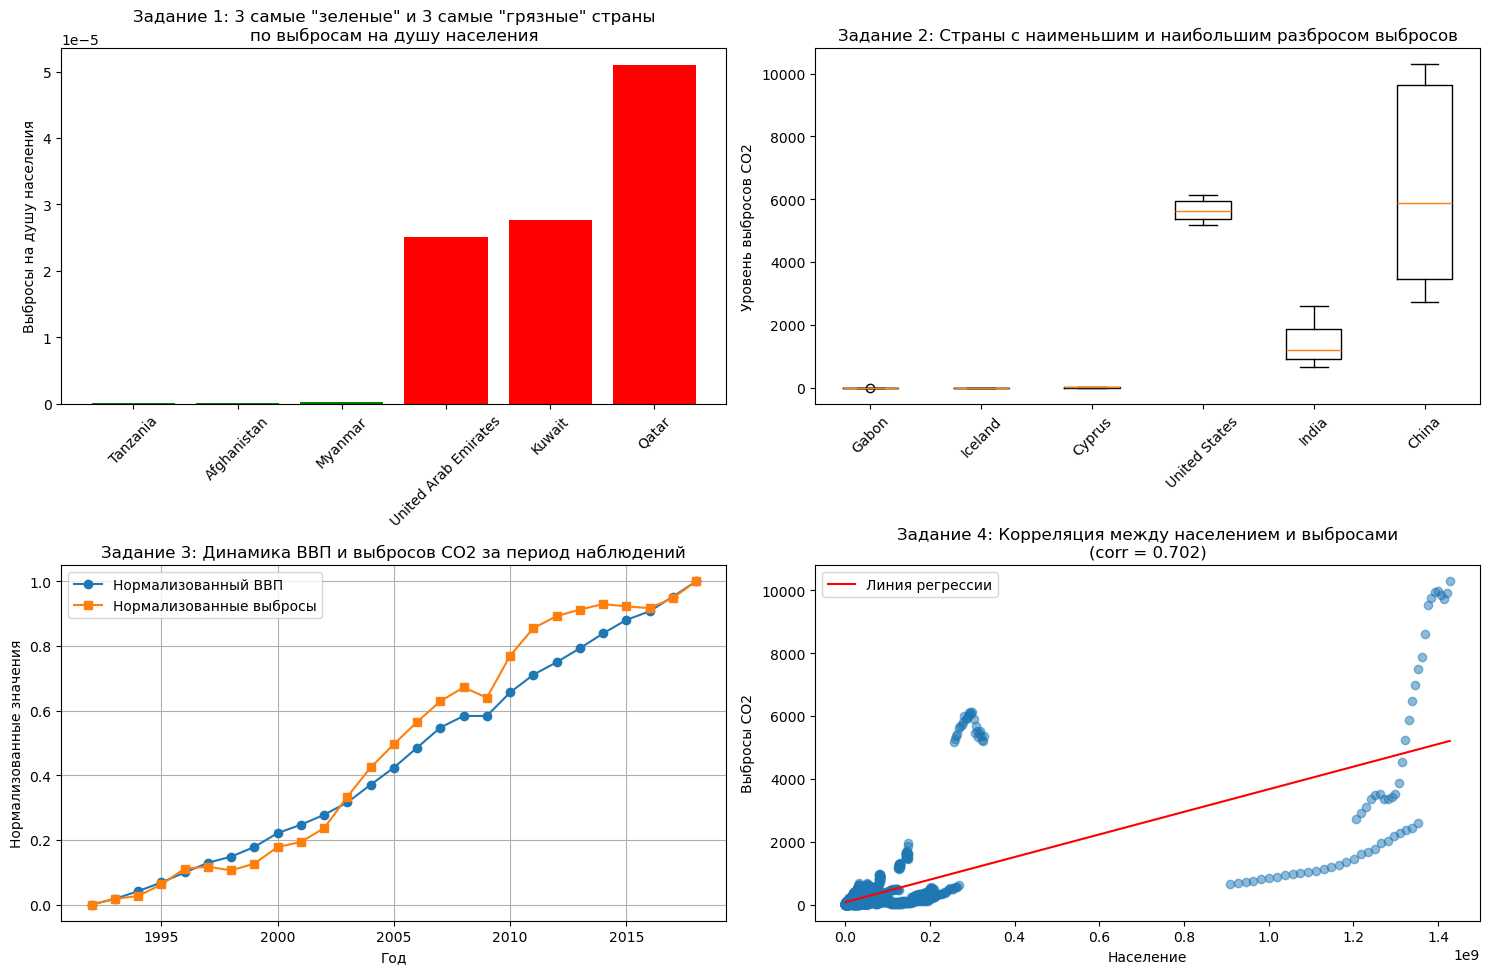

In [8]:
plot_all_results(
    (greenest, dirtiest),
    (lowest_var_data, lowest_var_names, highest_var_data, highest_var_names),
    (years, gdp_values, emissions_values),
    (population, emissions, correlation)
)